> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

## Multivariate Input ,Univariate Output LSTM ,Multi Step

This tutorial is to demonstrate the process in build LSTM for the **Multivariate Input Input ,Univariate Output LSTM ,Multi Step** .It consists of 2 major part which are :

The Demostration of Building LSTM using Synthetic data<br>
Exercise of building LSTM using Daily Demand Forecasting Orders data. <br>

First, we will show the step in building the LSTM :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Normalization and Batching the Data)<br>
Step 2. Model Configuration (Vanila LSTM , Stacked LSTM , Bidirectional LSTM)<br>
Step 3. Train the model<br>
Step 4. Validate the model using graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result

First , let's us import the package needed

In [1]:
# import libary need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math

In [2]:
# Data sequencing function for multivariate input , univariate output , multi step forecast
def multivariate_univariate_multi_step(sequence,window_size,n_multistep):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        out_ix = end_ix + n_multistep -1
        # check if we are beyond the sequence
        if out_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix-1:out_ix,-1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

## Hyperparameter
Define the hyper parameter that need to tune the model

In [3]:
split_ratio = 0.70
num_epochs = 300
window_size = 4
n_step = 2
learning_rate = 0.01
#seed
torch.manual_seed(123)

## Data Preparation
We create synthetic data to make sure the model is created correctly and having ability to perform the forecasting

In [4]:
#Synthetic Data
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])


# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

### Visualize the Synthetic Data

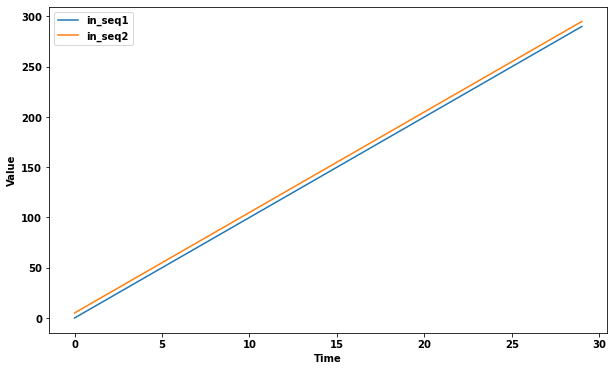

In [5]:
plt.figure(figsize=(10,6))
plt.plot(in_seq1, label="in_seq1")
plt.plot(in_seq2, label="in_seq2")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

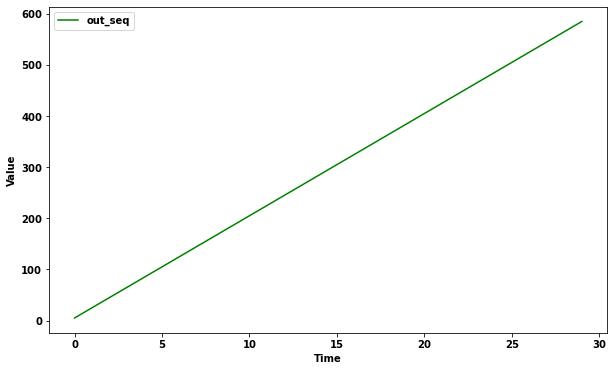

In [6]:
plt.figure(figsize=(10,6))
plt.plot(out_seq, label="out_seq",color='g')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

### Data Splitting

In [7]:
# Calculate the split ratio 
split_data = round(len(dataset)*split_ratio)
split_data

21

In [8]:
# Split data by indexing 
train_data = dataset[:split_data]
test_data = dataset[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


### Data Standardization
The data is scaled to mean = 0 , variance = 1

In [9]:
scaler = StandardScaler().fit((train_data.reshape(-1, 1)))
train_data_standardization = scaler.transform(train_data.reshape(-1, 1))
test_data_standardization = scaler.transform(test_data.reshape(-1, 1))

In [10]:
# Transform after scaling
train_data_standardization = train_data_standardization.reshape(train_data.shape[0],train_data.shape[1])
print("test_data_normalized"+str(train_data_standardization.shape))

test_data_standardization = test_data_standardization.reshape(test_data.shape[0],test_data.shape[1])
print("test_data_normalized"+str(test_data_standardization.shape))

test_data_normalized(21, 3)
test_data_normalized(9, 3)


### Data Sequencing
Sequencing the data

In [11]:
trainX ,trainY =  multivariate_univariate_multi_step(train_data_standardization,window_size,n_step)
testX , testY = multivariate_univariate_multi_step(test_data_standardization,window_size,n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(17, 4, 2) trainY shape:(17, 2)

testX shape:(5, 4, 2) testY shape:(5, 2)


### Data Transform
Data need to transform from numpy to pytorch tensor before feed into the model then perform 3D transformation to make it can feed into LSTM model 

In [12]:
# Make training and test sets in torch
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

In [13]:
# 3D Data Preparation
trainX = torch.reshape(trainX,(trainX.shape[0],trainX.shape[1],trainX.shape[2]))
trainY = torch.reshape(trainY,(trainY.shape[0],n_step))
testX = torch.reshape(testX,(testX.shape[0],trainX.shape[1],trainX.shape[2]))
testY = torch.reshape(testY,(testY.shape[0],n_step))

### Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [14]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=1,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=1,shuffle=False)

# LSTM Model Configuration

## Vanila LSTM
The method use to create the model is call pytorch subclass method. It consists of 2 part where the first part is allow user to define the structure of the model such as the **number of input unit**, **number of output unit** and **number of hidden unit** as well.

Second part of the method consist of forward() method , it allow user to control the flow of input data.

In [15]:
class LSTM(nn.Module):

        def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
            super(LSTM, self).__init__()

            self.n_feature = n_feature
            # Hidden dimensions
            self.hidden_dim = hidden_dim

            # Number of hidden layers
            self.num_layers = num_layers

            # Building your LSTM
            # batch_first=True causes input/output tensors to be of shape
            # (batch_dim, seq_dim, feature_dim)
            self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)

            # Readout layer
            self.fc = nn.Linear(hidden_dim, output_dim)


        def forward(self, x):
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # Initialize cell state
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # One time step
            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

            # Index hidden state of last time step
            # just want last time step hidden states!
            out = self.fc(out[:, -1, :])
            return out

## Bidirectional LSTM
The only different in the configuration of Bidirectional LSTM and Vanila LSTM is the number of layer need be multiplication of 2 or *2. For example :

self.fc = nn.Linear(hidden_dim 2, output_dim)<br>
h0 = torch.zeros(self.num_layers *2, x.size(0), self.hidden_dim)<br>
c0 = torch.zeros(self.num_layers *2, x.size(0), self.hidden_dim)<br>

In [16]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
        super(BidirectionalLSTM, self).__init__()

        self.n_feature = n_feature
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # Readout layer *2 for bidirectional LSTM
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        
        return out

## Input Model
The model is input by feed in the require attributes such as number of input layer, output layer and hidden layer.

How to Use :

Select one of the model base on the application as below and comment others model<br>
IF use Vanila LSTM , set num_layer = 1 and use the model = LSTM()<br>
IF use stacked LSTM , set num_layer more than 1 and use the model = LSTM()<br>
IF use Bidirectional LSTM, use the model = BidirectionalLSTM()

In [17]:
# Arguments for LSTM model
hidden_dim = 32
number_of_time_series = trainX.shape[2] 

# num_layers : 1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1
 
# Vanila , Stacked LSTM
model = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=n_step, num_layers=num_layers)

# Bidirectional LSTM
# model = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=n_step, num_layers=num_layers)

Define the MSE as loss function and using Adam as the model optimiser

In [18]:
# Use MSE as loss function 
loss_fn = torch.nn.MSELoss()

# Optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training 

In [19]:
def training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        running_loss_train = 0
        running_loss_valid = 0
        for _,(train_X,train_Y) in enumerate(train_iter):


            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape 
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))

            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            # Summing up the loss over each epoch
            running_loss_train += loss_train.item()

        # Average the loss base of the batch size
        epoch_loss_train = running_loss_train /len(train_X)
        
        # Store the averaged value
        train_loss[t] = epoch_loss_train

        # Validate the test data loss
        with torch.no_grad():
            for _,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to ensure the predicted output (y_test_pred) same size with test_y shape
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                
                # Calculate the loss
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each epoch
                running_loss_valid += loss_test.item()

        # Average the loss base of the batch size
        epoch_loss_test =running_loss_valid /len(test_X)

        # Store the averaged value
        val_loss[t] = epoch_loss_test
    
    return train_loss,val_loss

In [20]:
# Start Training
train_loss,val_loss = training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model)

## Evaluation
A learning curve loss is plotted to define how well the data is fitting the model

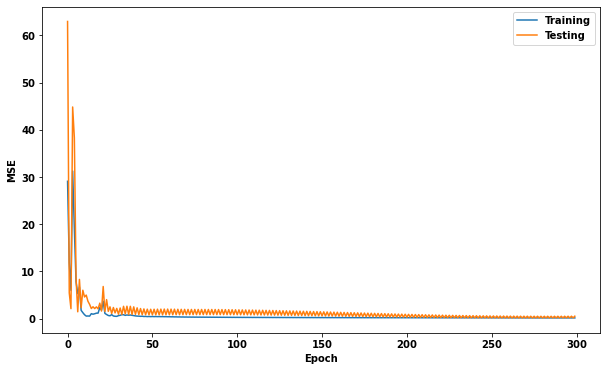

In [21]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<Br>
Section 2 : Reshape both train and test prediction back to the original data dimension<Br>
Section 3 : Invert the scaling back to orignal data value<Br>
Section 4 : Calculate the RMSE of train and test data

In [22]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

# Section 2 : Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [23]:
# Section 3 : Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [24]:
print("y-test\t\t\t\ty-predict")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

y-test				y-predict
[485.      504.99997]		[469.88898 491.4046 ]
[504.99997 525.     ]		[487.6042  506.96536]
[525. 545.]		[503.9669 518.9368]
[545. 565.]		[517.85266 525.4798 ]
[565. 585.]		[527.7589 524.402 ]


In [25]:
print(f"y_test_shape : {y_test.shape}")
print(f"y_test_pred_shape : {y_test_prediction.shape}")

y_test_shape : (5, 2)
y_test_pred_shape : (5, 2)


In [26]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.00 RMSE
Test Score: 24.89 RMSE


# Exercise for Multivariate Multistep (Solution)
Predict total number of demand of orders (Target Total Orders)
Data Source : https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Daily%20Demand%20Forecasting%20Orders

## Data Preparation

In [27]:
# Read the csv data 
demand = pd.read_csv(r"..\..\datasets\others\Daily_Demand_Forecasting_Orders.csv",sep=';')
demand.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


Reindex the data and make the Day start from Day 1 instead of Day 0 

In [28]:
demand.index.name = "Day"
demand = demand.reindex(index=range(1,len(demand)))
demand.loc[0:5]

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,,,
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
5,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364


Using sliding method to select the data column that we want to feed into model 

In [29]:
demand_slice = demand.iloc[:,2::]
demand_slice.loc[1:5,:]

,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,
1,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
5,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364


In [30]:
demand_value = demand_slice.values
demand_value.shape

(59, 11)

## Hyperparameter

In [54]:
#Hyperameter
split_ratio_demand = 0.70
num_epochs_demand  = 250
window_size_demand = 4
n_step_demand = 2
learning_rate_demand = 0.001
batch_size_demand = 2
#seed
torch.manual_seed(123)

## Data Splitting

In [55]:
split_data_demand = round(len(dataset)*split_ratio)
split_data_demand

21

In [56]:
#split data by indexing 
train_data_demand = demand_value[:-split_data_demand]
test_data_demand = demand_value[-split_data_demand:]
print("train_data_shape")
print(train_data_demand.shape)
print("test_data_shape")
print(test_data_demand.shape)

train_data_shape
(38, 11)
test_data_shape
(21, 11)


## Data Standardization

In [57]:
# Data Standardization
scaler = StandardScaler().fit(train_data_demand.reshape(-1, 1))
train_data_standardization_demand  = scaler.transform(train_data_demand.reshape(-1, 1))
test_data_standardization_demand = scaler.transform(test_data_demand.reshape(-1, 1))

In [58]:
# Transform after scaling
train_data_standardization_demand = train_data_standardization_demand .reshape(train_data_demand.shape[0],train_data_demand.shape[1])
print("test_data_normalized"+str(train_data_standardization_demand.shape))

test_data_standardization_demand = test_data_standardization_demand.reshape(test_data_demand.shape[0],test_data_demand.shape[1])
print("test_data_normalized"+str(test_data_standardization_demand.shape))

test_data_normalized(38, 11)
test_data_normalized(21, 11)


## Data Seqeuncing

In [59]:
trainX_demand ,trainY_demand =  multivariate_univariate_multi_step(train_data_standardization_demand,window_size_demand,n_step_demand)
testX_demand , testY_demand = multivariate_univariate_multi_step(test_data_standardization_demand,window_size_demand,n_step_demand)
print(f"trainX_demand shape:{trainX_demand.shape} trainY_demand shape:{trainY_demand.shape}\n")
print(f"testX_demand shape:{testX_demand.shape} testX_demand shape:{testY_demand.shape}")

trainX_demand shape:(34, 4, 10) trainY_demand shape:(34, 2)

testX_demand shape:(17, 4, 10) testX_demand shape:(17, 2)


##  Data Transform

In [60]:
# Make training and test sets in torch
trainX_demand = torch.from_numpy(trainX_demand).type(torch.Tensor)
trainY_demand = torch.from_numpy(trainY_demand).type(torch.Tensor)
testX_demand = torch.from_numpy(testX_demand).type(torch.Tensor)
testY_demand = torch.from_numpy(testY_demand).type(torch.Tensor)

# 3D Data Preparation
trainX_demand = torch.reshape(trainX_demand,(trainX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],n_step_demand))
testX_demand = torch.reshape(testX_demand,(testX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],n_step_demand))

In [61]:
# Print to check the data dimension
print(f"trainX_demand shape : {trainX_demand.shape}")
print(f"trainY_demand shape : {trainY_demand.shape}")
print(f"testX_demand shape  : {testX_demand.shape}")
print(f"testY_demand_demand shape : {testY_demand.shape}")

trainX_demand shape : torch.Size([34, 4, 10])
trainY_demand shape : torch.Size([34, 2])
testX_demand shape  : torch.Size([17, 4, 10])
testY_demand_demand shape : torch.Size([17, 2])


## Data Iterator

In [62]:
# Create Iterator
train_dataset_demand = TensorDataset(trainX_demand, trainY_demand)
train_iter_demand = DataLoader(train_dataset_demand,batch_size=batch_size_demand,shuffle=False)

test_dataset_demand = TensorDataset(testX_demand, testY_demand)
test_iter_demand = DataLoader(test_dataset_demand,batch_size=batch_size_demand,shuffle=False)

## Input Model
The model is input by feed in the require attributes such as number of input layer, output layer and hidden layer.

How to Use :

Select one of the model base on the application as below and comment others model<br>
IF use Vanila LSTM , set num_layer = 1 and use the model = LSTM()<br>
IF use stacked LSTM , set num_layer more than 1 and use the model = LSTM()<br>
IF use Bidirectional LSTM, use the model = BidirectionalLSTM()<br>

In [63]:
# Arguments for LSTM model
hidden_dim_demand = 64
number_of_time_series_demand = trainX_demand.shape[2] 

# 1 for vanila LSTM , >1 is mean stacked LSTM
num_layers_demand = 3

# Vanila , Stacked LSTM
model_demand = LSTM(n_feature=number_of_time_series_demand, hidden_dim=hidden_dim_demand, output_dim=n_step_demand, num_layers=num_layers_demand)

# Bidirectional LSTM
# model_demand = BidirectionalLSTM(n_feature=number_of_time_series_demand, hidden_dim=hidden_dim_demand, output_dim=n_step_demand, num_layers=num_layers_demand)

Define the MSE as loss function and using Adam as the model optimiser

In [64]:
#loss function 
loss_fn_demand = torch.nn.MSELoss()

#optimiser
optimiser_demand = torch.optim.Adam(model_demand.parameters(), lr=learning_rate_demand)

## Training

In [65]:
train_loss_demand,val_loss_demand = training(num_epochs_demand,train_iter_demand,test_iter_demand,
                                           optimiser = optimiser_demand,
                                           loss_fn = loss_fn_demand,
                                            model=model_demand)

## Evaluate
The first part is plot the Train loss & Test loss as the training goes on

The second part serve as a function to zoom in certain period on Train loss & Test loss graph to have a clear visualize cause sometime the loss will skew and make us hard to determine the best fit epoch .

For example : The learning curve is skew heavily on the left ,the remaining losses is hard to visualize

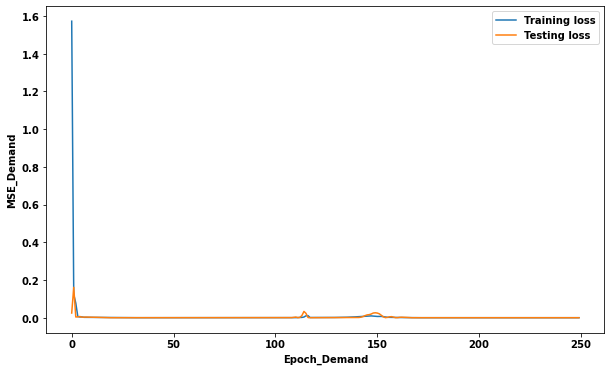

In [66]:
# Learning curve of model_demand
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand, label="Training loss")
plt.plot(val_loss_demand, label="Testing loss")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
plt.legend()
plt.show()

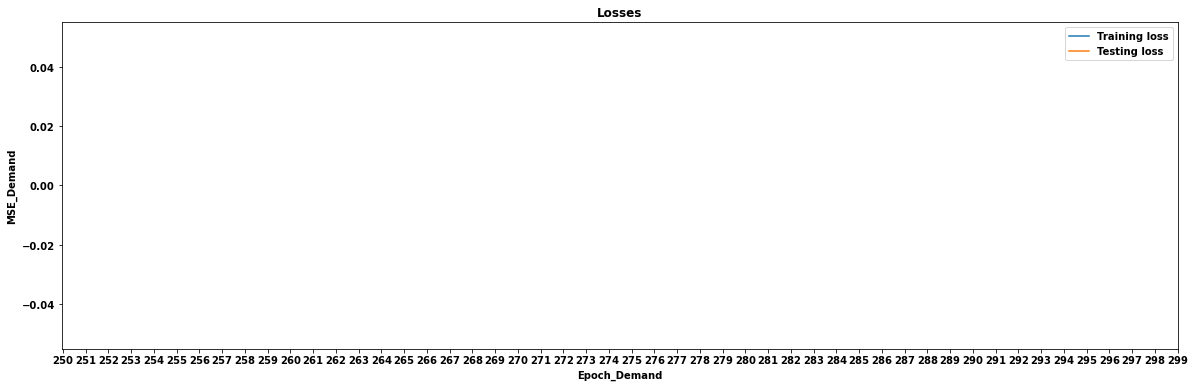

In [67]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 250
end_epoch = 300
plt.figure(figsize=(20,6))
plt.plot(train_loss_demand[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_demand[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

## Inference
This section is to inference the model and plot the forecast result

In [68]:
# Inference 
with torch.no_grad():
    y_train_prediction_demand = model_demand(trainX_demand)
    y_test_prediction_demand = model_demand(testX_demand)

# Reshape to original data
y_train_prediction_demand = torch.reshape(y_train_prediction_demand,(y_train_prediction_demand.shape[0],y_train_prediction_demand.shape[1]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],trainY_demand.shape[1]))
y_test_prediction_demand = torch.reshape(y_test_prediction_demand,(y_test_prediction_demand.shape[0],y_test_prediction_demand.shape[1]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],testY_demand.shape[1]))

In [69]:
# Invert predictions
y_train_prediction_demand = scaler.inverse_transform(y_train_prediction_demand.detach().numpy())
y_train_demand = scaler.inverse_transform(trainY_demand.detach().numpy())
y_test_prediction_demand = scaler.inverse_transform(y_test_prediction_demand.detach().numpy())
y_test_demand = scaler.inverse_transform(testY_demand.detach().numpy())

In [70]:
print("y-test_demand\t\t\t\ty-predict_demand")
for i in range(len(y_test_prediction_demand)):
    print(f"{y_test_demand[i]}\t\t{y_test_prediction_demand[i]}")

y-test_demand				y-predict_demand
[234.50386 234.72456]		[268.7812  369.76947]
[234.72456 230.06245]		[267.70892 311.34174]
[230.06245 357.39447]		[290.16986 244.27534]
[357.39447 259.24603]		[340.61908 235.7148 ]
[259.24603 244.23433]		[301.31244 211.71284]
[244.23433 402.60736]		[301.29877 224.51753]
[402.60736 255.0605 ]		[289.0722 236.8769]
[255.0605 342.6054]		[306.59564 235.03902]
[342.6054 268.6386]		[367.61517 233.67964]
[268.6386  188.60152]		[322.74408 212.83784]
[188.60152 202.02339]		[266.03705 218.2148 ]
[202.02339 213.50777]		[269.59174 272.61127]
[213.50777 316.8476 ]		[304.61713 246.78316]
[316.8476  286.41205]		[368.30658 235.53511]
[286.41205 303.4472 ]		[348.8847  218.73628]
[303.4472  304.94916]		[372.32025 235.5644 ]
[304.94916 331.90033]		[377.373   263.01556]


In [71]:
print(f"y_test_demand_shape : {y_test_demand.shape}")
print(f"y_test_demand_pred_shape : {y_test_prediction_demand.shape}")

y_test_demand_shape : (17, 2)
y_test_demand_pred_shape : (17, 2)


In [72]:
# Calculate root mean squared error
trainScore_demand = math.sqrt(mean_squared_error(y_train_demand[:,0], y_train_prediction_demand[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_demand))
testScore_demand = math.sqrt(mean_squared_error(y_test_demand[:,0], y_test_prediction_demand[:,0]))
print('Test Score: %.2f RMSE' % (testScore_demand))

Train Score: 52.14 RMSE
Test Score: 62.16 RMSE


## Plot Explanation
- Blue Line-Indicate as test data before sequencing 
- Green Line-Indicate as the testY data after sequencing 
- Red Line-Indicate as the predicted testY data (Forecast) after sequencing

Window size = 4 , hence the time need start from +3 due to taking 3 data point as x-feature. 
  - **x-feature = window size -1**

[ time+3,time+4 ] - This is because n_step_demand = 2 .If n_step_demand = 3 ,[ time+3,time+4,time_5 ] is need 

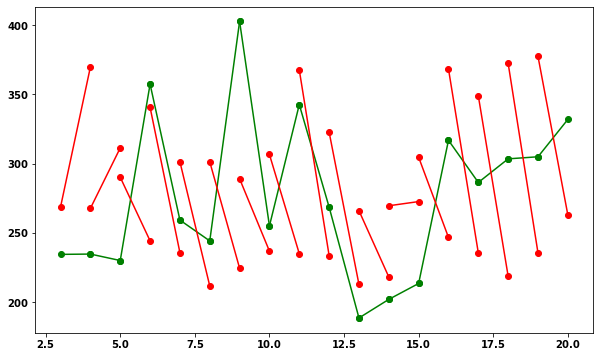

In [73]:
# Plot testY and predictionY data
plt.figure(figsize=(10,6))
for time in range(17):
        TestY_data=[y_test_demand[time][0],y_test_demand[time][1]]
        plt.plot([time+3,time+4],TestY_data,color="green",marker='o',label='TestY')
    
        textY_data=[y_test_prediction_demand[time][0],y_test_prediction_demand[time][1]]
        b = plt.plot([time+3,time+4], textY_data,color="red",marker='o',label='Forecast')


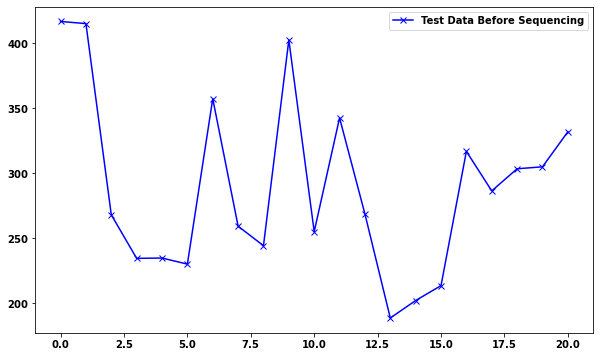

In [74]:
# Plot Original Test Data
plt.figure(figsize=(10,6))
plt.plot(test_data_demand[:,-1],marker='x',color="blue",label="Test Data Before Sequencing")
plt.legend()

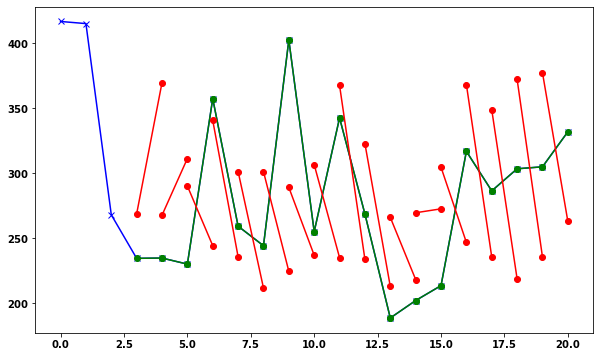

In [75]:
# Plot orginal test data , testY and predict testY after sequencing 
plt.figure(figsize=(10,6))
plt.plot(test_data_demand[:,-1],marker='x',color="blue",label="Test Data Before Sequencing")
for time in range(17):
        TestY_data=[y_test_demand[time][0],y_test_demand[time][1]]
        plt.plot([time+3,time+4],TestY_data,color="green",marker='o',label='TestY')
        
        textY_data=[y_test_prediction_demand[time][0],y_test_prediction_demand[time][1]]
        b = plt.plot([time+3,time+4], textY_data,color="red",marker='o',label='Forecast')

## Reference
1. [Multistep Time Series Forecasting with LSTMs in Python](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/)
2. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)